In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_excel('./data/Book.xlsx')
import theano
theano.__version__

# To simulate model parameters make True
run_inference = False

In [3]:
# adding a column of minutes in the data
mins = []
for r in range(len(data)):
    mins.append(data.iloc[r]['time']//60) 
    
data['minute'] = mins

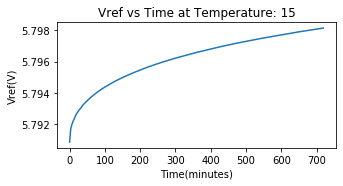

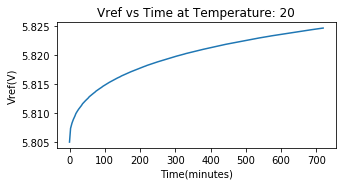

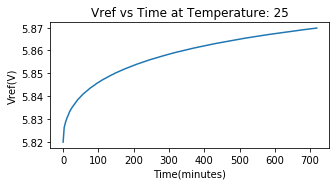

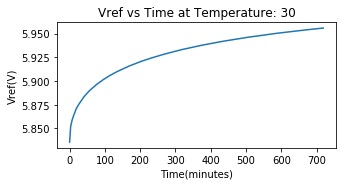

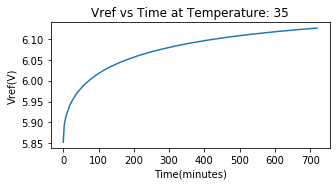

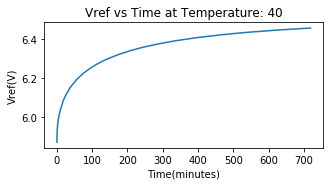

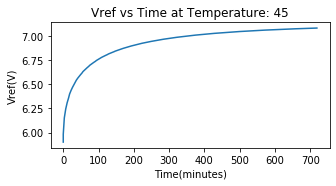

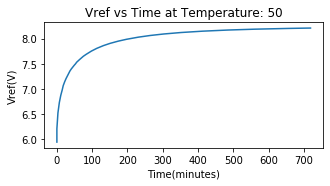

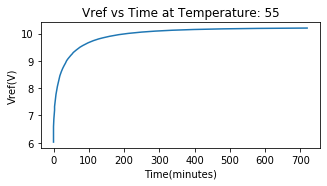

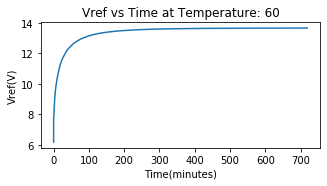

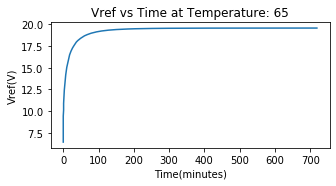

In [4]:
# plotting vref vs time plot for temperature in range 15 to 65 with a gap of 5 deg C

'''
count = 1
for T in range(15,66,5):
    time = data[data['Temperature'] == T]['minute']
    vref = data[data['Temperature'] == T]['V(vref)']
    fig = plt.figure(figsize=(5,30))
    plt.subplot(11,1,count)
    plt.plot(time,vref)
    plt.title("Vref vs Time at Temperature: %s" %T)
    plt.xlabel('Time(minutes)')
    plt.ylabel('Vref(V)')
    count += 1
'''

In [5]:
'''
Initializing model
Vref = epsilon - alpha * exp(-beta*time)
'''

def inferring_parameters(time, vref):
    model_isfet = pm.Model()
    
    with model_isfet:
        alpha = pm.Uniform('alpha',0,15)
        beta = pm.Uniform('beta',0,15)
        epsilon = pm.Uniform('epsilon', 0,20)
        sd_vref = pm.Uniform('vref_sd', 0,1)
        voltage = pm.Normal('Voltage',mu = epsilon - alpha*np.exp(-beta*time), sigma=sd_vref,observed=vref)
        step = pm.Metropolis()
        trace = pm.sample(200000, step=step)
    
    return trace

In [6]:
Traces = {}
if run_inference == True:
    for T in range(15,66,5):
        print("Working on Temperaure: ", T)
        time = data[data['Temperature'] == T]['minute']
        vref = data[data['Temperature'] == T]['V(vref)']
        trace = inferring_parameters(time, vref)
        Traces[T] = trace
    
    for k in Traces.keys():
        df = pm.backends.tracetab.trace_to_dataframe(Traces[k])
        df.to_csv(str(k)+'_trace.csv')
        print('saved traces!')
        
for T in range(15,66,5):
    Traces[T] = pd.read_csv('../Trace/%s_trace.csv'%T, index_col=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


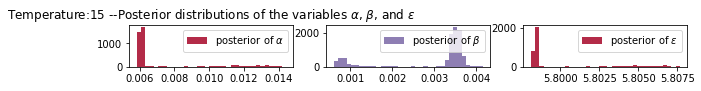

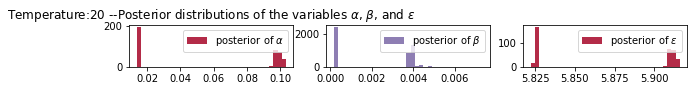

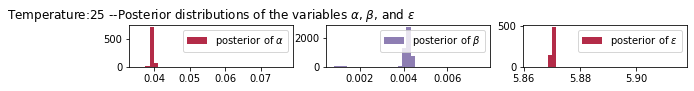

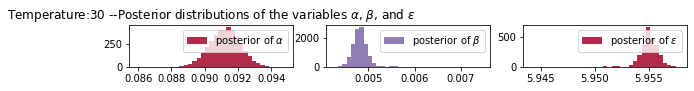

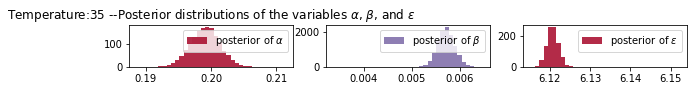

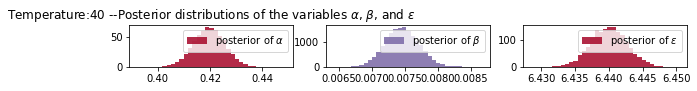

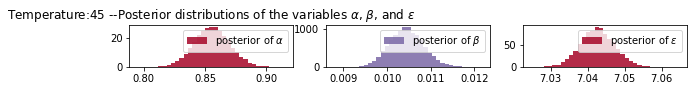

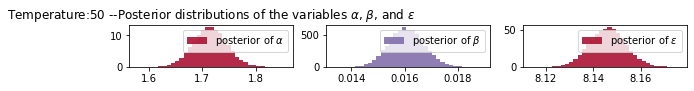

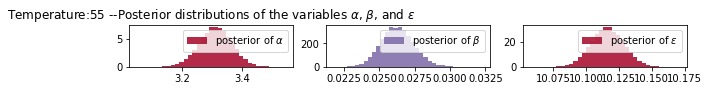

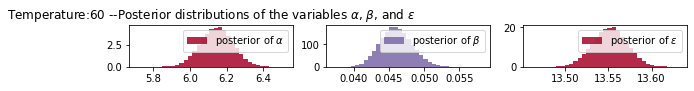

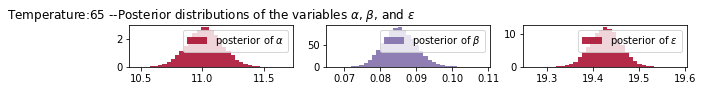

In [8]:
count = 0
for T in range(15,66,5):
    alpha_samples = Traces[T]["alpha"][400000:]
    beta_samples = Traces[T]["beta"][400000:]
    epsilon_samples = Traces[T]["epsilon"][400000:]

    fig = plt.figure(figsize=(10, 10))
    #histogram of the samples:
    plt.subplot(11,3,3*count+1)
    plt.title(r"Temperature:%s --Posterior distributions of the variables $\alpha$, $\beta$, and $\epsilon$"%T)
    plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
             label=r"posterior of $\alpha$", color="#A60628", normed=True)
    plt.legend();

    plt.subplot(11,3,3*count+2)
    plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
             label=r"posterior of $\beta$", color="#7A68A6", normed=True)
    plt.legend()

    plt.subplot(11,3,3*count+3)
    plt.hist(epsilon_samples, histtype='stepfilled', bins=35, alpha=0.85,
             label=r"posterior of $\epsilon$", color="#A60628", normed=True)
    plt.legend();
    count += 1
    

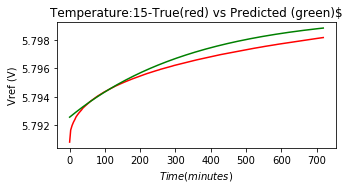

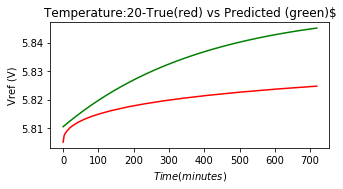

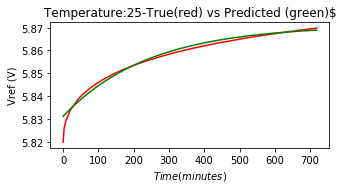

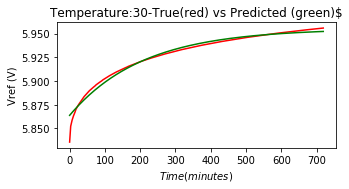

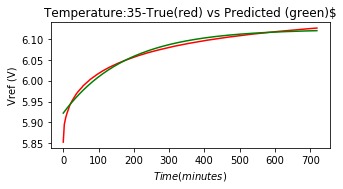

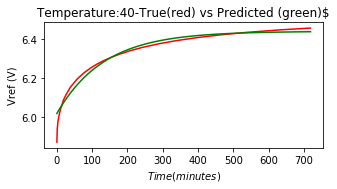

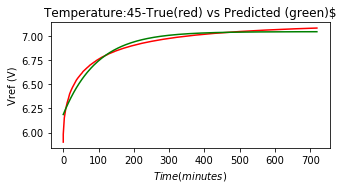

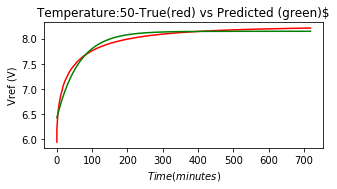

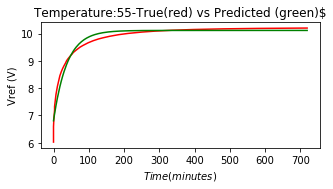

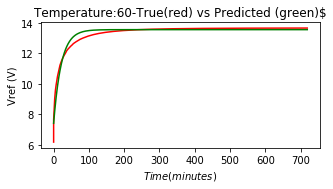

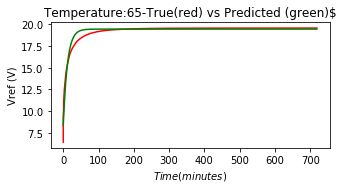

In [9]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error

Te = []
ev = []
r2 = []
mse = []
mae = []
count = 1
for T in range(15,66,5):
    alpha_samples = Traces[T]["alpha"][100000:]
    beta_samples = Traces[T]["beta"][100000:]
    epsilon_samples = Traces[T]["epsilon"][100000:]
    
    epsilon_mean = epsilon_samples.mean()
    alpha_mean = alpha_samples.mean()
    beta_mean = beta_samples.mean()
    
    #From data
    time = data[data['Temperature'] == T]['minute']
    vref = data[data['Temperature'] == T]['V(vref)']

    #predictied
    vref_pred = epsilon_mean - alpha_mean*np.exp(-beta_mean*time)

    fig = plt.figure(figsize=(5, 30))
    plt.subplot(11,1,count)
    plt.title(r"Temperature:%s-True(red) vs Predicted (green)$"%T)
    plt.xlabel('$Time (minutes)$')
    plt.ylabel('Vref (V)')
    plt.plot(time, vref, 'r', time, vref_pred, 'g')
    
    #Errors
    Te.append(T)
    ev.append(explained_variance_score(vref, vref_pred))
    r2.append(r2_score(vref, vref_pred))
    mse.append(mean_squared_error(vref, vref_pred))
    mae.append(mean_absolute_error(vref, vref_pred))
    
    count += 1
    
#Saving the results
errors = pd.DataFrame()
errors['Temperature'] = Te
errors['Explained_variance'] = ev
errors['R2'] = r2
errors['MSE'] = mse
errors['MAE'] = mae

errors.to_csv('Results.csv')

In [10]:
print(errors)

    Temperature  Explained_variance         R2           MSE       MAE
0            15            0.967501   0.874614  3.074757e-07  0.000480
1            20           -0.945855 -10.948644  2.045699e-04  0.013086
2            25            0.984605   0.983483  1.747489e-06  0.000917
3            30            0.982172   0.982171  1.019730e-05  0.002135
4            35            0.978158   0.977526  6.004372e-05  0.005234
5            40            0.971081   0.971081  3.336827e-04  0.012582
6            45            0.963126   0.963126  1.622082e-03  0.028581
7            50            0.958336   0.958336  6.380983e-03  0.057906
8            55            0.963146   0.963146  2.085633e-02  0.101007
9            60            0.968676   0.968676  6.201823e-02  0.160910
10           65            0.974090   0.974090  1.801229e-01  0.243031
